In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys

sys.path.append("/kvh4/optic_disc/scripts") 
from training import train_dice, train_bce, train_dice_MC, run_inference, run_MC_inference, run_ensemble_inference
from evaluation_functions import compute_dice_dataset, \
                                    compute_max_softmax_uncertainty_dataset, load_pred, compute_mean_uncertainty_dataset,\
                                    compute_mean_pw_dice_dataset

## Load Dataset Splits
on run once

In [2]:
filepath = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training"
with open(os.path.join(filepath, "dataset_splits_nonglaucoma_600_100.pkl"), 'rb') as file:
    data_dict = pickle.load(file)

In [3]:
glaucoma_image_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/images"
glaucoma_images = [os.path.join(glaucoma_image_dir, g) for g in os.listdir(glaucoma_image_dir)]
glaucoma_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"
glaucoma_gt = [os.path.join(glaucoma_gt_dir, g) for g in os.listdir(glaucoma_gt_dir)]

In [4]:
gt_dir_ng ="/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
gt_dir_g = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"

In [5]:
def eval_mean_uncertainty(gt_dir_ng, gt_dir_g, pred_dir_training, pred_dir_test, pred_dir_g, sampling=False):
    evaluation_data_dir = dict() # contains the dice scores and everything from the three datasets 
    
    train_names = [n[-9:-4] for n in os.listdir(pred_dir_training)]
    test_names = [n[-9:-4] for n in os.listdir(pred_dir_test)]
    g_names = [n[-9:-4] for n in os.listdir(pred_dir_g)]
    
    # training data 
    res_train = compute_dice_dataset(train_names, gt_dir_ng, pred_dir_training, mode="cup", sampling=sampling)
    train_dice = np.mean(list(res_train.values()))
    unc_train = compute_mean_uncertainty_dataset(train_names, pred_dir_training, sampling=sampling)
    dice_train = list()
    ms_unc_train = list()
    for k in res_train.keys():
        dice_train.append(res_train[k])
        ms_unc_train.append(unc_train[k])
    evaluation_data_dir["train_dice"] = dice_train
    evaluation_data_dir["train_ms"] = ms_unc_train
    
    # test data 
    res_test = compute_dice_dataset(test_names, gt_dir_ng, pred_dir_test, mode="cup", sampling=sampling)
    test_dice = np.mean(list(res_test.values()))
    unc_test = compute_mean_uncertainty_dataset(test_names, pred_dir_test, sampling=sampling)
    dice_test = list()
    ms_unc_test = list()
    for k in res_test.keys():
        dice_test.append(res_test[k])
        ms_unc_test.append(unc_test[k])
    evaluation_data_dir["test_dice"] = dice_test
    evaluation_data_dir["test_ms"] = ms_unc_test
    
    # glaucoma data 
    res_g = compute_dice_dataset(g_names, gt_dir_g, pred_dir_g, mode="cup", sampling=sampling)
    g_dice = np.mean(list(res_g.values()))
    unc_g = compute_mean_uncertainty_dataset(g_names, pred_dir_g, sampling=sampling)
    dice_g = list()
    ms_unc_g = list()
    for k in res_g.keys():
        dice_g.append(res_g[k])
        ms_unc_g.append(unc_g[k])
    evaluation_data_dir["glaucoma_dice"] = dice_g
    evaluation_data_dir["glaucoma_ms"] = ms_unc_g
    
    plt.scatter(dice_train, ms_unc_train, label="training, "+str(round(train_dice, 3)))
    plt.scatter(dice_test, ms_unc_test, label="test non-glaucoma, "+str(round(test_dice, 3)))
    plt.scatter(dice_g, ms_unc_g, label="test glaucoma, "+str(round(g_dice, 3)))
    
    plt.ylabel("mean uncertainty")
    plt.xlabel("Dice score")
    plt.legend()
    
    return evaluation_data_dir

In [6]:
def eval_mean_pw_dice(gt_dir_ng, gt_dir_g, pred_dir_training, pred_dir_test, pred_dir_g):
    evaluation_data_dir = dict() # contains the dice scores and everything from the three datasets 
    
    train_names = [n[-9:-4] for n in os.listdir(pred_dir_training)]
    test_names = [n[-9:-4] for n in os.listdir(pred_dir_test)]
    g_names = [n[-9:-4] for n in os.listdir(pred_dir_g)]
    
    # training data 
    res_train = compute_dice_dataset(train_names, gt_dir_ng, pred_dir_training, mode="cup", sampling=True)
    train_dice = np.mean(list(res_train.values()))
    unc_train = compute_mean_pw_dice_dataset(train_names, pred_dir_training)
    dice_train = list()
    ms_unc_train = list()
    for k in res_train.keys():
        dice_train.append(res_train[k])
        ms_unc_train.append(unc_train[k])
    evaluation_data_dir["train_dice"] = dice_train
    evaluation_data_dir["train_ms"] = ms_unc_train
    
    # test data 
    res_test = compute_dice_dataset(test_names, gt_dir_ng, pred_dir_test, mode="cup", sampling=True)
    test_dice = np.mean(list(res_test.values()))
    unc_test = compute_mean_pw_dice_dataset(test_names, pred_dir_test)
    dice_test = list()
    ms_unc_test = list()
    for k in res_test.keys():
        dice_test.append(res_test[k])
        ms_unc_test.append(unc_test[k])
    evaluation_data_dir["test_dice"] = dice_test
    evaluation_data_dir["test_ms"] = ms_unc_test
    
    # glaucoma data 
    res_g = compute_dice_dataset(g_names, gt_dir_g, pred_dir_g, mode="cup", sampling=True)
    g_dice = np.mean(list(res_g.values()))
    unc_g = compute_mean_pw_dice_dataset(g_names, pred_dir_g)
    dice_g = list()
    ms_unc_g = list()
    for k in res_g.keys():
        dice_g.append(res_g[k])
        ms_unc_g.append(unc_g[k])
    evaluation_data_dir["glaucoma_dice"] = dice_g
    evaluation_data_dir["glaucoma_ms"] = ms_unc_g
    
    plt.scatter(dice_train, ms_unc_train, label="training, "+str(round(train_dice, 3)))
    plt.scatter(dice_test, ms_unc_test, label="test non-glaucoma, "+str(round(test_dice, 3)))
    plt.scatter(dice_g, ms_unc_g, label="test glaucoma, "+str(round(g_dice, 3)))
    
    plt.ylabel("mean pw Dice")
    plt.xlabel("Dice score")
    plt.legend()
    
    return evaluation_data_dir

## no dropout 
### seed = 0 

In [15]:
training_params_0 = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/00_UNet_cup",
                  "p_dropout": 0.0,
                    "p_weight": 10}

In [16]:
filepath = training_params_0["model_dir"]
if not os.path.exists(filepath):
    os.makedirs(filepath)
    
with open(os.path.join(filepath, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_0, file)

In [ ]:
train_bce(**training_params_0)

----------
epoch 1/150
epoch 1 average loss: 0.8284
savepath:  /kvh4/optic_disc/models/bce_ensemble/00_UNet_cup/epoch_1.pth
saved model
current epoch: 1 current mean dice: 0.0676
val loss:  0.7191707319021226
----------
epoch 2/150
epoch 2 average loss: 0.7317
savepath:  /kvh4/optic_disc/models/bce_ensemble/00_UNet_cup/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.0853
val loss:  0.7198277086019516
----------
epoch 3/150
epoch 3 average loss: 0.6663
savepath:  /kvh4/optic_disc/models/bce_ensemble/00_UNet_cup/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.1027
val loss:  0.6765340781211853
----------
epoch 4/150
epoch 4 average loss: 0.6189
savepath:  /kvh4/optic_disc/models/bce_ensemble/00_UNet_cup/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.1250
val loss:  0.6377877426147461
----------
epoch 5/150
epoch 5 average loss: 0.5826
savepath:  /kvh4/optic_disc/models/bce_ensemble/00_UNet_cup/epoch_5.pth
saved model
current epoch: 5 current mea

current epoch: 39 current mean dice: 0.7195
val loss:  0.14158512346446514
----------
epoch 40/150
epoch 40 average loss: 0.1054
savepath:  /kvh4/optic_disc/models/bce_ensemble/00_UNet_cup/epoch_40.pth
saved model
current epoch: 40 current mean dice: 0.7081
val loss:  0.1402617172151804
----------
epoch 41/150
epoch 41 average loss: 0.1005
savepath:  /kvh4/optic_disc/models/bce_ensemble/00_UNet_cup/epoch_41.pth
saved model
current epoch: 41 current mean dice: 0.7358
val loss:  0.13095832750201225
----------
epoch 42/150


In [49]:
filepath = "/kvh4/optic_disc/models/bce_ensemble/00_UNet_cup"# new filepatch 
train_loss = np.load(os.path.join(filepath, "epoch_loss.npy"))
val_loss = np.load(os.path.join(filepath, "val_loss.npy"))
val_metrics = np.load(os.path.join(filepath, "val_metrics.npy"))

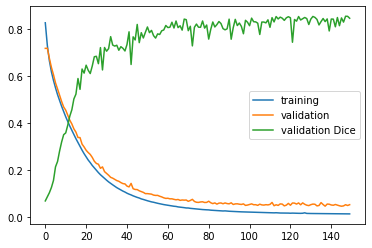

In [50]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [71]:
np.argmax(val_metrics)

147

In [80]:
eval_epoch_0 = 147

In [73]:
inference_parameters_test_0 = {"model_dir": training_params_0["model_dir"], 
                         "model_epoch": eval_epoch_0,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_0["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_0))}

In [74]:
run_inference(**inference_parameters_test_0)

finished inference


In [75]:
inference_parameters_train_0 = {"model_dir": training_params_0["model_dir"], 
                         "model_epoch": eval_epoch_0,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_0["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_0))}

In [76]:
run_inference(**inference_parameters_train_0)

finished inference


In [77]:
inference_parameters_glaucoma_0 = {"model_dir": training_params_0["model_dir"], 
                         "model_epoch": eval_epoch_0,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_0["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_0))}

In [78]:
run_inference(**inference_parameters_glaucoma_0)

finished inference


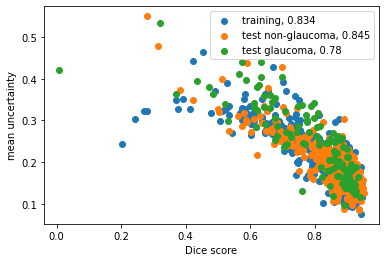

In [79]:
# epoch 147
model_dir = training_params_0["model_dir"]
eval_dict_0 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_0)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_0)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_0)), 
             "sampling": False}

dice_seed_0_eval = eval_mean_uncertainty(**eval_dict_0)

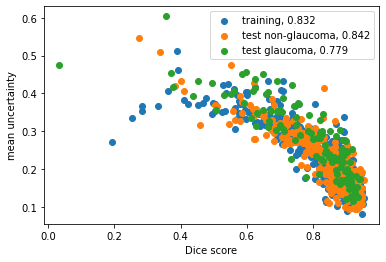

In [69]:
# epoch 100
model_dir = training_params_0["model_dir"]
eval_dict_0 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_0)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_0)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_0)), 
             "sampling": False}

dice_seed_0_eval = eval_mean_uncertainty(**eval_dict_0)

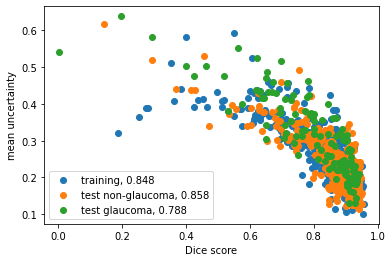

In [70]:
# epoch 69
eval_epoch_0 = 69
model_dir = training_params_0["model_dir"]
eval_dict_0 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_0)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_0)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_0)), 
             "sampling": False}

dice_seed_0_eval = eval_mean_uncertainty(**eval_dict_0)

## seed = 1

In [21]:
training_params_1 = {"seed": 1, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/01_UNet_cup",
                  "p_dropout": 0.0,
                    "p_weight": 10}

In [22]:
model_path = training_params_1["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_1, file)

In [ ]:
train_bce(**training_params_1)

----------
epoch 1/150
epoch 1 average loss: 0.9289
savepath:  /kvh4/optic_disc/models/bce_ensemble/01_UNet_cup/epoch_1.pth
saved model
current epoch: 1 current mean dice: 0.0355
val loss:  0.8244830840826034
----------
epoch 2/150
epoch 2 average loss: 0.7872
savepath:  /kvh4/optic_disc/models/bce_ensemble/01_UNet_cup/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.0587
val loss:  0.7687197709083557
----------
epoch 3/150
epoch 3 average loss: 0.7057
savepath:  /kvh4/optic_disc/models/bce_ensemble/01_UNet_cup/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.0696
val loss:  0.7217792516946793
----------
epoch 4/150
epoch 4 average loss: 0.6557
savepath:  /kvh4/optic_disc/models/bce_ensemble/01_UNet_cup/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.0870
val loss:  0.6752148067951202
----------
epoch 5/150
epoch 5 average loss: 0.6162
savepath:  /kvh4/optic_disc/models/bce_ensemble/01_UNet_cup/epoch_5.pth
saved model
current epoch: 5 current mea

In [121]:
model_path = training_params_1["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

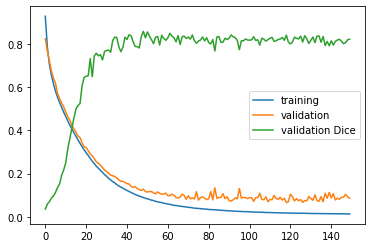

In [82]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [122]:
np.argmax(val_metrics[100:])

18

In [123]:
eval_epoch_1 = 119

In [124]:
inference_parameters_training_1 = {"model_dir": training_params_1["model_dir"], 
                         "model_epoch": eval_epoch_1,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_1["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_1))}

In [125]:
run_inference(**inference_parameters_training_1)

finished inference


In [126]:
inference_parameters_test_1 = {"model_dir": training_params_1["model_dir"], 
                         "model_epoch": eval_epoch_1,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_1["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_1))}

In [127]:
run_inference(**inference_parameters_test_1)

finished inference


In [128]:
inference_parameters_glaucoma_1 = {"model_dir": training_params_1["model_dir"], 
                         "model_epoch": eval_epoch_1,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_1["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_1))}

In [129]:
run_inference(**inference_parameters_glaucoma_1)

finished inference


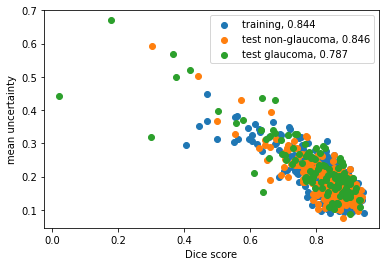

In [130]:
model_dir = training_params_1["model_dir"]
eval_dict_1 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_1)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_1)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_1)), 
             "sampling": False}

dice_seed_1_eval = eval_mean_uncertainty(**eval_dict_1)

In [18]:
eval_epoch_1 = 150
model_dir = "/kvh4/optic_disc/models/bce_ensemble/01_UNet_cup"

In [19]:
inference_parameters_training_1 = {"model_dir": model_dir, 
                         "model_epoch": eval_epoch_1,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(model_dir, \
                                                  "training_pred_epoch_"+str(eval_epoch_1))}

In [20]:
run_inference(**inference_parameters_training_1)

finished inference


In [21]:
inference_parameters_test_1 = {"model_dir": model_dir, 
                         "model_epoch": eval_epoch_1,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(model_dir, \
                                                  "test_pred_epoch_"+str(eval_epoch_1))}

In [22]:
run_inference(**inference_parameters_test_1)

finished inference


In [23]:
inference_parameters_glaucoma_1 = {"model_dir": model_dir, 
                         "model_epoch": eval_epoch_1,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(model_dir, \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_1))}

In [24]:
run_inference(**inference_parameters_glaucoma_1)

finished inference


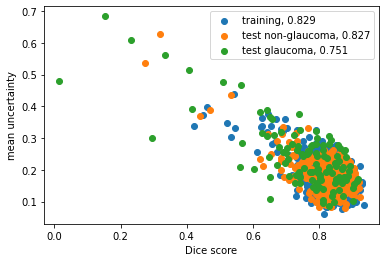

In [25]:
eval_dict_1 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_1)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_1)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_1)), 
             "sampling": False}

dice_seed_1_eval = eval_mean_uncertainty(**eval_dict_1)

### seed = 2

In [26]:
training_params_2 = {"seed": 2, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/02_UNet_cup",
                  "p_dropout": 0.0, 
                    "p_weight": 10}

In [ ]:
model_path = training_params_2["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_2, file)

In [ ]:
train_bce(**training_params_2)

In [86]:
model_path = training_params_2["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

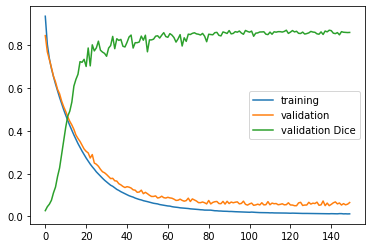

In [87]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [88]:
np.argmax(val_metrics)

139

In [131]:
eval_epoch_2 = 140

In [132]:
inference_parameters_training_2 = {"model_dir": training_params_2["model_dir"], 
                         "model_epoch": eval_epoch_2,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_2["model_dir"], "training_pred_epoch_"+str(eval_epoch_2))}

In [133]:
run_inference(**inference_parameters_training_2)

finished inference


In [134]:
inference_parameters_test_2 = {"model_dir": training_params_2["model_dir"], 
                         "model_epoch": eval_epoch_2,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_2["model_dir"], "test_pred_epoch_"+str(eval_epoch_2))}

In [135]:
run_inference(**inference_parameters_test_2)

finished inference


In [136]:
inference_parameters_glaucoma_2 = {"model_dir": training_params_2["model_dir"], 
                         "model_epoch": eval_epoch_2,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_2["model_dir"], "glaucoma_pred_epoch_"+str(eval_epoch_2))}

In [137]:
run_inference(**inference_parameters_glaucoma_2)

finished inference


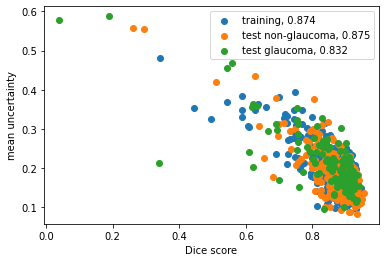

In [138]:
model_dir = training_params_2["model_dir"]
eval_dict_2 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_2)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_2)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_2)), 
             "sampling": False}

dice_seed_2_eval = eval_mean_uncertainty(**eval_dict_2)

### seed = 3

In [27]:
training_params_3 = {"seed": 3, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/03_UNet_cup",
                  "p_dropout": 0.0, 
                    "p_weight": 10}

In [ ]:
model_path = training_params_3["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_3, file)

In [ ]:
train_bce(**training_params_3)

In [90]:
model_path = training_params_3["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

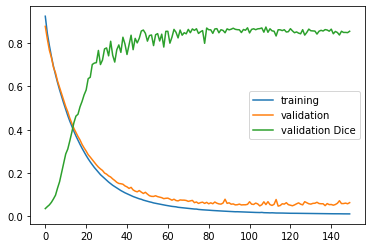

In [91]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [92]:
np.argmax(val_metrics)

108

In [139]:
eval_epoch_3 = 109

In [140]:
inference_parameters_training_3 = {"model_dir": training_params_3["model_dir"], 
                         "model_epoch": eval_epoch_3,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_3["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_3))}

In [141]:
run_inference(**inference_parameters_training_3)

finished inference


In [142]:
inference_parameters_test_3 = {"model_dir": training_params_3["model_dir"], 
                         "model_epoch": eval_epoch_3,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_3["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_3))}

In [143]:
run_inference(**inference_parameters_test_3)

finished inference


In [144]:
inference_parameters_glaucoma_3 = {"model_dir": training_params_3["model_dir"], 
                         "model_epoch": eval_epoch_3,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_3["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_3))}

In [145]:
run_inference(**inference_parameters_glaucoma_3)

finished inference


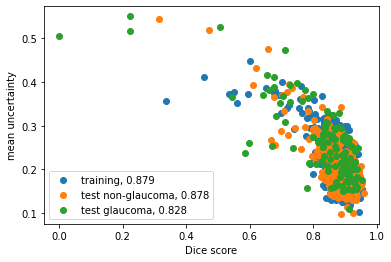

In [146]:
model_dir = training_params_3["model_dir"]
eval_dict_3 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_3)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_3)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_3)), 
             "sampling": False}

dice_seed_3_eval = eval_mean_uncertainty(**eval_dict_3)

In [28]:
eval_epoch_3 = 150

In [29]:
inference_parameters_training_3 = {"model_dir": training_params_3["model_dir"], 
                         "model_epoch": eval_epoch_3,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_3["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_3))}

In [30]:
run_inference(**inference_parameters_training_3)

finished inference


In [31]:
inference_parameters_test_3 = {"model_dir": training_params_3["model_dir"], 
                         "model_epoch": eval_epoch_3,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_3["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_3))}

In [32]:
run_inference(**inference_parameters_test_3)

finished inference


In [33]:
inference_parameters_glaucoma_3 = {"model_dir": training_params_3["model_dir"], 
                         "model_epoch": eval_epoch_3,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_3["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_3))}

In [34]:
run_inference(**inference_parameters_glaucoma_3)

finished inference


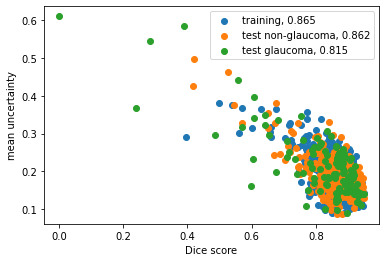

In [35]:
model_dir = training_params_3["model_dir"]
eval_dict_3 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_3)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_3)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_3)), 
             "sampling": False}

dice_seed_3_eval = eval_mean_uncertainty(**eval_dict_3)

### seed = 4

In [ ]:
training_params_4 = {"seed": 4, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/04_UNet_cup",
                  "p_dropout": 0.0,
                    "p_weight": 10}

In [ ]:
model_path = training_params_4["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_4, file)

In [ ]:
train_bce(**training_params_4)

In [94]:
model_path = training_params_4["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

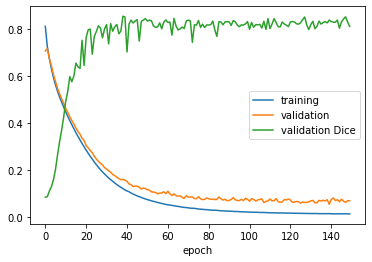

In [95]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [147]:
np.argmax(val_metrics)

48

In [148]:
eval_epoch_4 = 149

In [149]:
inference_parameters_training_4 = {"model_dir": training_params_4["model_dir"], 
                         "model_epoch": eval_epoch_4,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_4["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_4))}

In [150]:
run_inference(**inference_parameters_training_4)

finished inference


In [151]:
inference_parameters_test_4 = {"model_dir": training_params_4["model_dir"], 
                         "model_epoch": eval_epoch_4,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_4["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_4))}

In [152]:
run_inference(**inference_parameters_test_4)

finished inference


In [153]:
inference_parameters_glaucoma_4 = {"model_dir": training_params_4["model_dir"], 
                         "model_epoch": eval_epoch_4,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_4["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_4))}

In [154]:
run_inference(**inference_parameters_glaucoma_4)

finished inference


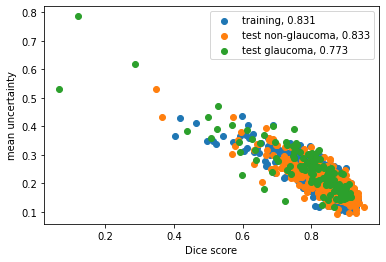

In [155]:
model_dir = training_params_4["model_dir"]
eval_dict_4 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_4)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_4)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_4)), 
             "sampling": False}

dice_seed_4_eval = eval_mean_uncertainty(**eval_dict_4)

### seed = 5

In [ ]:
training_params_5 = {"seed": 5, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/05_UNet_cup",
                  "p_dropout": 0.0,
                    "p_weight": 10}

In [ ]:
model_path = training_params_5["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_5, file)

In [ ]:
train_bce(**training_params_5)

In [99]:
model_path = training_params_5["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

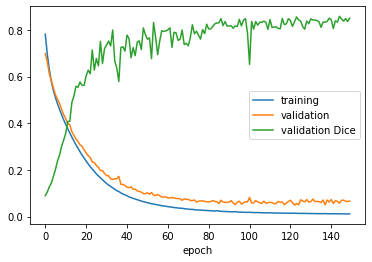

In [100]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [101]:
np.argmax(val_metrics)

144

In [156]:
eval_epoch_5 = 145

In [157]:
inference_parameters_training_5 = {"model_dir": training_params_5["model_dir"], 
                         "model_epoch": eval_epoch_5,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_5["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_5))}

In [158]:
run_inference(**inference_parameters_training_5)

finished inference


In [159]:
inference_parameters_test_5 = {"model_dir": training_params_5["model_dir"], 
                         "model_epoch": eval_epoch_5,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_5["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_5))}

In [160]:
run_inference(**inference_parameters_test_5)

finished inference


In [161]:
inference_parameters_glaucoma_5 = {"model_dir": training_params_5["model_dir"], 
                         "model_epoch": eval_epoch_5,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_5["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_5))}

In [162]:
run_inference(**inference_parameters_glaucoma_5)

finished inference


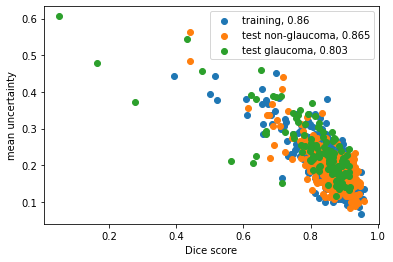

In [163]:
model_dir = training_params_5["model_dir"]
eval_dict_5 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_5)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_5)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_5)), 
             "sampling": False}

dice_seed_5_eval = eval_mean_uncertainty(**eval_dict_5)

### seed = 6

In [ ]:
training_params_6 = {"seed": 6, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/06_UNet_cup",
                  "p_dropout": 0.0,
                    "p_weight": 10}

In [ ]:
model_path = training_params_6["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_6, file)

In [ ]:
train_bce(**training_params_6)

In [103]:
model_path = training_params_6["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

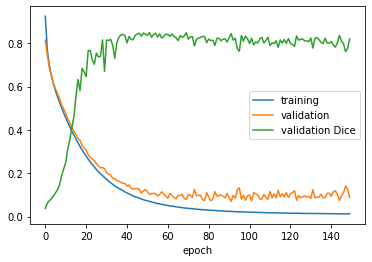

In [104]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [105]:
np.argmax(val_metrics[100:])

44

In [168]:
eval_epoch_6 = 145

In [169]:
inference_parameters_training_6 = {"model_dir": training_params_6["model_dir"], 
                         "model_epoch": eval_epoch_6,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_6["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_6))}

In [170]:
run_inference(**inference_parameters_training_6)

finished inference


In [171]:
inference_parameters_test_6 = {"model_dir": training_params_6["model_dir"], 
                         "model_epoch": eval_epoch_6,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_6["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_6))}

In [172]:
run_inference(**inference_parameters_test_6)

finished inference


In [173]:
inference_parameters_glaucoma_6 = {"model_dir": training_params_6["model_dir"], 
                         "model_epoch": eval_epoch_6,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_6["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_6))}

In [174]:
run_inference(**inference_parameters_glaucoma_6)

finished inference


Mean of empty slice.
invalid value encountered in true_divide


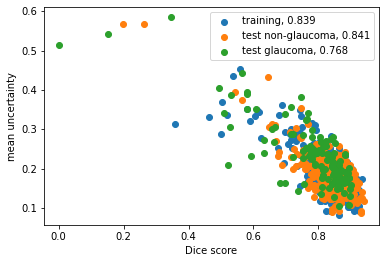

In [175]:
model_dir = training_params_6["model_dir"]
eval_dict_6 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_6)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_6)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_6)), 
             "sampling": False}

dice_seed_6_eval = eval_mean_uncertainty(**eval_dict_6)

### seed = 7

In [36]:
training_params_7 = {"seed": 7, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/07_UNet_cup",
                  "p_dropout": 0.0, 
                     "p_weight": 10}

In [ ]:
model_path = training_params_7["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_7, file)

In [ ]:
train_bce(**training_params_7)

In [107]:
model_path = training_params_7["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

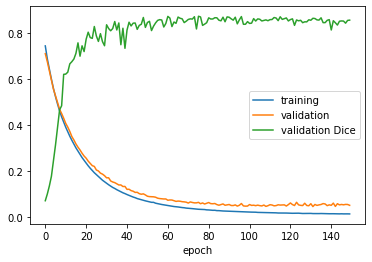

In [108]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [110]:
np.argmax(val_metrics[100:])

15

In [176]:
eval_epoch_7 = 116

In [177]:
inference_parameters_training_7 = {"model_dir": training_params_7["model_dir"], 
                         "model_epoch": eval_epoch_7,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_7["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_7))}

In [178]:
run_inference(**inference_parameters_training_7)

finished inference


In [179]:
inference_parameters_test_7 = {"model_dir": training_params_7["model_dir"], 
                         "model_epoch": eval_epoch_7,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_7["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_7))}

In [180]:
run_inference(**inference_parameters_test_7)

finished inference


In [181]:
inference_parameters_glaucoma_7 = {"model_dir": training_params_7["model_dir"], 
                         "model_epoch": eval_epoch_7,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_7["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_7))}

In [182]:
run_inference(**inference_parameters_glaucoma_7)

finished inference


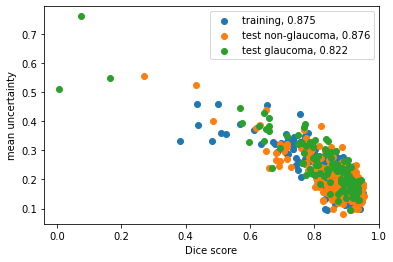

In [183]:
model_dir = training_params_7["model_dir"]
eval_dict_7 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_7)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_7)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_7)), 
             "sampling": False}

dice_seed_7_eval = eval_mean_uncertainty(**eval_dict_7)

In [37]:
eval_epoch_7 = 150

In [38]:
inference_parameters_training_7 = {"model_dir": training_params_7["model_dir"], 
                         "model_epoch": eval_epoch_7,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_7["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_7))}

In [39]:
run_inference(**inference_parameters_training_7)

finished inference


In [40]:
inference_parameters_test_7 = {"model_dir": training_params_7["model_dir"], 
                         "model_epoch": eval_epoch_7,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_7["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_7))}

In [41]:
run_inference(**inference_parameters_test_7)

finished inference


In [42]:
inference_parameters_glaucoma_7 = {"model_dir": training_params_7["model_dir"], 
                         "model_epoch": eval_epoch_7,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_7["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_7))}

In [43]:
run_inference(**inference_parameters_glaucoma_7)

finished inference


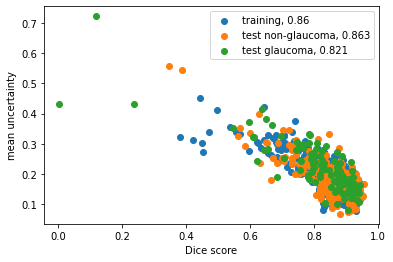

In [44]:
model_dir = training_params_7["model_dir"]
eval_dict_7 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_7)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_7)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_7)), 
             "sampling": False}

dice_seed_7_eval = eval_mean_uncertainty(**eval_dict_7)

### seed = 8

In [45]:
training_params_8 = {"seed": 8, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/08_UNet_cup",
                  "p_dropout": 0.0,
                    "p_weight": 10}

In [ ]:
model_path = training_params_8["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_8, file)

In [ ]:
train_bce(**training_params_8)

In [112]:
model_path = training_params_8["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

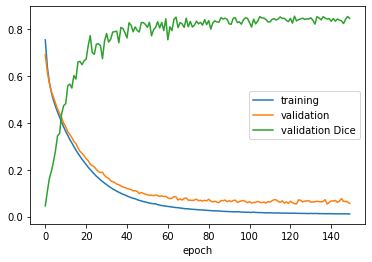

In [113]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [114]:
np.argmax(val_metrics)

122

In [184]:
eval_epoch_8 = 123

In [185]:
inference_parameters_training_8 = {"model_dir": training_params_8["model_dir"], 
                         "model_epoch": eval_epoch_8,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_8["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_8))}

In [186]:
run_inference(**inference_parameters_training_8)

finished inference


In [187]:
inference_parameters_test_8 = {"model_dir": training_params_8["model_dir"], 
                         "model_epoch": eval_epoch_8,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_8["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_8))}

In [188]:
run_inference(**inference_parameters_test_8)

finished inference


In [189]:
inference_parameters_glaucoma_8 = {"model_dir": training_params_8["model_dir"], 
                         "model_epoch": eval_epoch_8,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_8["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_8))}

In [190]:
run_inference(**inference_parameters_glaucoma_8)

finished inference


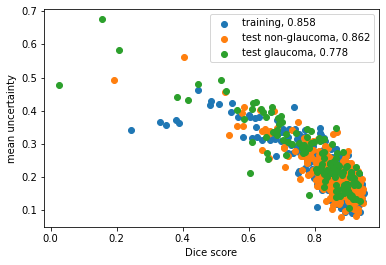

In [191]:
model_dir = training_params_8["model_dir"]
eval_dict_8 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_8)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_8)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_8)), 
             "sampling": False}

dice_seed_8_eval = eval_mean_uncertainty(**eval_dict_8)

In [46]:
eval_epoch_8 = 149

In [47]:
inference_parameters_training_8 = {"model_dir": training_params_8["model_dir"], 
                         "model_epoch": eval_epoch_8,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_8["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_8))}

In [48]:
run_inference(**inference_parameters_training_8)

finished inference


In [49]:
inference_parameters_test_8 = {"model_dir": training_params_8["model_dir"], 
                         "model_epoch": eval_epoch_8,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_8["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_8))}

In [50]:
run_inference(**inference_parameters_test_8)

finished inference


In [51]:
inference_parameters_glaucoma_8 = {"model_dir": training_params_8["model_dir"], 
                         "model_epoch": eval_epoch_8,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_8["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_8))}

In [52]:
run_inference(**inference_parameters_glaucoma_8)

finished inference


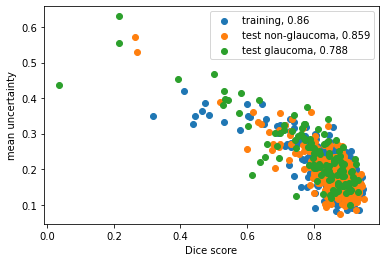

In [53]:
model_dir = training_params_8["model_dir"]
eval_dict_8 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_8)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_8)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_8)), 
             "sampling": False}

dice_seed_8_eval = eval_mean_uncertainty(**eval_dict_8)

### seed = 9

In [54]:
training_params_9 = {"seed": 9, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 150,
                  "model_dir": "/kvh4/optic_disc/models/bce_ensemble/09_UNet_cup",
                  "p_dropout": 0.0, 
                    "p_weight": 10}

In [ ]:
model_path = training_params_9["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_9, file)

In [ ]:
train_bce(**training_params_9)

In [116]:
model_path = training_params_9["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

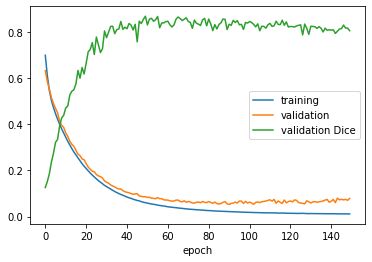

In [117]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [119]:
np.argmax(val_metrics[100:])

16

In [192]:
eval_epoch_9 = 117

In [193]:
inference_parameters_training_9 = {"model_dir": training_params_9["model_dir"], 
                         "model_epoch": eval_epoch_9,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_9["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_9))}

In [194]:
run_inference(**inference_parameters_training_9)

finished inference


In [195]:
inference_parameters_test_9 = {"model_dir": training_params_9["model_dir"], 
                         "model_epoch": eval_epoch_9,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_9["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_9))}

In [196]:
run_inference(**inference_parameters_test_9)

finished inference


In [197]:
inference_parameters_glaucoma_9 = {"model_dir": training_params_9["model_dir"], 
                         "model_epoch": eval_epoch_9,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_9["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_9))}

In [198]:
run_inference(**inference_parameters_glaucoma_9)

finished inference


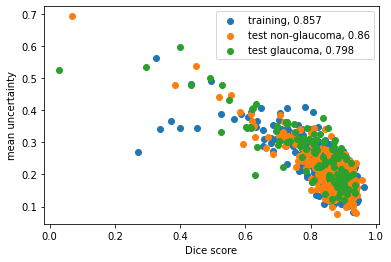

In [199]:
model_dir = training_params_9["model_dir"]
eval_dict_9 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_9)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_9)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_9)), 
             "sampling": False}

dice_seed_9_eval = eval_mean_uncertainty(**eval_dict_9)

In [55]:
eval_epoch_9 = 147

In [56]:
inference_parameters_training_9 = {"model_dir": training_params_9["model_dir"], 
                         "model_epoch": eval_epoch_9,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_9["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_9))}

In [57]:
run_inference(**inference_parameters_training_9)

finished inference


In [58]:
inference_parameters_test_9 = {"model_dir": training_params_9["model_dir"], 
                         "model_epoch": eval_epoch_9,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_9["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_9))}

In [59]:
run_inference(**inference_parameters_test_9)

finished inference


In [60]:
inference_parameters_glaucoma_9 = {"model_dir": training_params_9["model_dir"], 
                         "model_epoch": eval_epoch_9,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_9["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_9))}

In [61]:
run_inference(**inference_parameters_glaucoma_9)

finished inference


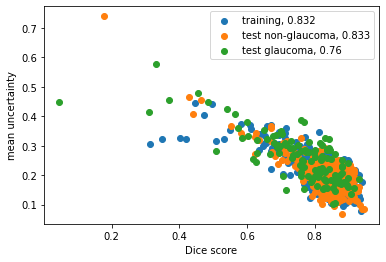

In [62]:
model_dir = training_params_9["model_dir"]
eval_dict_9 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_9)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_9)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_9)), 
             "sampling": False}

dice_seed_9_eval = eval_mean_uncertainty(**eval_dict_9)

## Ensemble inference and evaluation

In [7]:
ensemble_inference_params_test = {"ensemble_dir": "/kvh4/optic_disc/models/bce_ensemble",
                            "model_name_list": ["00_UNet_cup/epoch_147.pth", "01_UNet_cup/epoch_119.pth",
                                               "02_UNet_cup/epoch_140.pth", "03_UNet_cup/epoch_109.pth",
                                               "04_UNet_cup/epoch_149.pth", "05_UNet_cup/epoch_145.pth",
                                               "06_UNet_cup/epoch_145.pth", "07_UNet_cup/epoch_116.pth",
                                               "08_UNet_cup/epoch_123.pth", "09_UNet_cup/epoch_117.pth"],
                            "test_images": data_dict["test_images"],
                            "test_gt": data_dict["test_gt"],
                            "save_dir": "/kvh4/optic_disc/models/bce_ensemble/test_pred"}

run_ensemble_inference(**ensemble_inference_params_test)

finished inference


In [9]:
ensemble_inference_params_training = {"ensemble_dir": "/kvh4/optic_disc/models/bce_ensemble",
                            "model_name_list": ["00_UNet_cup/epoch_147.pth", "01_UNet_cup/epoch_119.pth",
                                               "02_UNet_cup/epoch_140.pth", "03_UNet_cup/epoch_109.pth",
                                               "04_UNet_cup/epoch_149.pth", "05_UNet_cup/epoch_145.pth",
                                               "06_UNet_cup/epoch_145.pth", "07_UNet_cup/epoch_116.pth",
                                               "08_UNet_cup/epoch_123.pth", "09_UNet_cup/epoch_117.pth"],
                            "test_images": data_dict["training_images"],
                            "test_gt": data_dict["training_gt"],
                            "save_dir": "/kvh4/optic_disc/models/bce_ensemble/training_pred"}

run_ensemble_inference(**ensemble_inference_params_training)

finished inference


In [10]:
ensemble_inference_params_glaucoma = {"ensemble_dir": "/kvh4/optic_disc/models/bce_ensemble",
                            "model_name_list": ["00_UNet_cup/epoch_147.pth", "01_UNet_cup/epoch_119.pth",
                                               "02_UNet_cup/epoch_140.pth", "03_UNet_cup/epoch_109.pth",
                                               "04_UNet_cup/epoch_149.pth", "05_UNet_cup/epoch_145.pth",
                                               "06_UNet_cup/epoch_145.pth", "07_UNet_cup/epoch_116.pth",
                                               "08_UNet_cup/epoch_123.pth", "09_UNet_cup/epoch_117.pth"],
                            "test_images": glaucoma_images,
                            "test_gt": glaucoma_gt,
                            "save_dir": "/kvh4/optic_disc/models/bce_ensemble/glaucoma_pred"}

run_ensemble_inference(**ensemble_inference_params_glaucoma)

finished inference


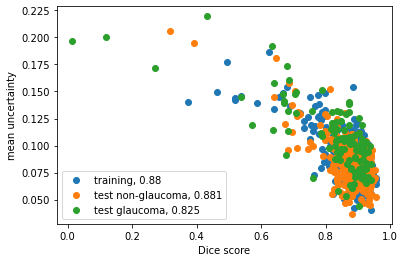

In [11]:
eval_dict_ensemble = {"gt_dir_ng": gt_dir_ng, 
                      "gt_dir_g": gt_dir_g,  
                      "pred_dir_training": "/kvh4/optic_disc/models/bce_ensemble/training_pred",
                      "pred_dir_test": "/kvh4/optic_disc/models/bce_ensemble/test_pred", 
                      "pred_dir_g": "/kvh4/optic_disc/models/bce_ensemble/glaucoma_pred", 
                      "sampling":True
                     }
dice_ensemble_eval = eval_mean_uncertainty(**eval_dict_ensemble)

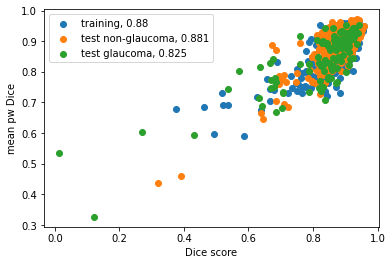

In [15]:
eval_dict_ensemble = {"gt_dir_ng": gt_dir_ng, 
                      "gt_dir_g": gt_dir_g,  
                      "pred_dir_training": "/kvh4/optic_disc/models/bce_ensemble/training_pred",
                      "pred_dir_test": "/kvh4/optic_disc/models/bce_ensemble/test_pred", 
                      "pred_dir_g": "/kvh4/optic_disc/models/bce_ensemble/glaucoma_pred",
                     }
dice_ensemble_eval = eval_mean_pw_dice(**eval_dict_ensemble)

## Ensemble inference and evaluation - 2 

In [63]:
ensemble_inference_params_test = {"ensemble_dir": "/kvh4/optic_disc/models/bce_ensemble",
                            "model_name_list": ["00_UNet_cup/epoch_147.pth", "01_UNet_cup/epoch_150.pth",
                                               "02_UNet_cup/epoch_140.pth", "03_UNet_cup/epoch_150.pth",
                                               "04_UNet_cup/epoch_149.pth", "05_UNet_cup/epoch_145.pth",
                                               "06_UNet_cup/epoch_145.pth", "07_UNet_cup/epoch_150.pth",
                                               "08_UNet_cup/epoch_149.pth", "09_UNet_cup/epoch_147.pth"],
                            "test_images": data_dict["test_images"],
                            "test_gt": data_dict["test_gt"],
                            "save_dir": "/kvh4/optic_disc/models/bce_ensemble/test_pred_2"}

run_ensemble_inference(**ensemble_inference_params_test)

finished inference


In [64]:
ensemble_inference_params_training = {"ensemble_dir": "/kvh4/optic_disc/models/bce_ensemble",
                            "model_name_list": ["00_UNet_cup/epoch_147.pth", "01_UNet_cup/epoch_150.pth",
                                               "02_UNet_cup/epoch_140.pth", "03_UNet_cup/epoch_150.pth",
                                               "04_UNet_cup/epoch_149.pth", "05_UNet_cup/epoch_145.pth",
                                               "06_UNet_cup/epoch_145.pth", "07_UNet_cup/epoch_150.pth",
                                               "08_UNet_cup/epoch_149.pth", "09_UNet_cup/epoch_147.pth"],
                            "test_images": data_dict["training_images"],
                            "test_gt": data_dict["training_gt"],
                            "save_dir": "/kvh4/optic_disc/models/bce_ensemble/training_pred_2"}

run_ensemble_inference(**ensemble_inference_params_training)

finished inference


In [65]:
ensemble_inference_params_glaucoma = {"ensemble_dir": "/kvh4/optic_disc/models/bce_ensemble",
                            "model_name_list": ["00_UNet_cup/epoch_147.pth", "01_UNet_cup/epoch_150.pth",
                                               "02_UNet_cup/epoch_140.pth", "03_UNet_cup/epoch_150.pth",
                                               "04_UNet_cup/epoch_149.pth", "05_UNet_cup/epoch_145.pth",
                                               "06_UNet_cup/epoch_145.pth", "07_UNet_cup/epoch_150.pth",
                                               "08_UNet_cup/epoch_149.pth", "09_UNet_cup/epoch_147.pth"],
                            "test_images": glaucoma_images,
                            "test_gt": glaucoma_gt,
                            "save_dir": "/kvh4/optic_disc/models/bce_ensemble/glaucoma_pred_2"}

run_ensemble_inference(**ensemble_inference_params_glaucoma)

finished inference


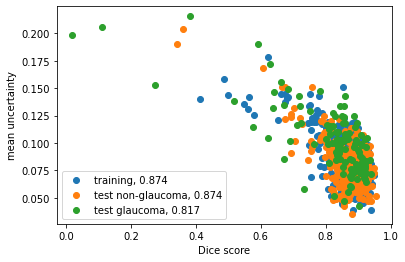

In [66]:
eval_dict_ensemble = {"gt_dir_ng": gt_dir_ng, 
                      "gt_dir_g": gt_dir_g,  
                      "pred_dir_training": "/kvh4/optic_disc/models/bce_ensemble/training_pred_2",
                      "pred_dir_test": "/kvh4/optic_disc/models/bce_ensemble/test_pred_2", 
                      "pred_dir_g": "/kvh4/optic_disc/models/bce_ensemble/glaucoma_pred_2", 
                      "sampling":True
                     }
dice_ensemble_eval = eval_mean_uncertainty(**eval_dict_ensemble)

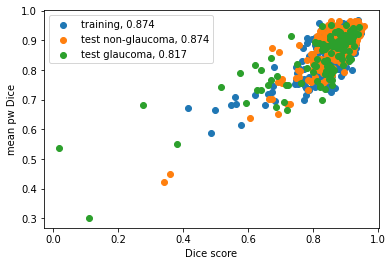

In [67]:
eval_dict_ensemble = {"gt_dir_ng": gt_dir_ng, 
                      "gt_dir_g": gt_dir_g,  
                      "pred_dir_training": "/kvh4/optic_disc/models/bce_ensemble/training_pred_2",
                      "pred_dir_test": "/kvh4/optic_disc/models/bce_ensemble/test_pred_2", 
                      "pred_dir_g": "/kvh4/optic_disc/models/bce_ensemble/glaucoma_pred_2",
                     }
dice_ensemble_eval = eval_mean_pw_dice(**eval_dict_ensemble)